In [ ]:
# Cell 1: Install Dependencies and Setup for Skin Disease Detection
!pip install -q kaggle tensorflow matplotlib seaborn scikit-learn
!pip install -q datasets pillow opencv-python
!pip install -q tensorflow-hub
!pip install -q albumentations

import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

print("✅ Dependencies installed successfully!")
print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ GPU Available: {tf.config.list_physical_devices('GPU')}")

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU memory growth configured")
    except RuntimeError as e:
        print(f"⚠️ GPU configuration error: {e}")

print("🔬 Skin Disease Detection System Initialized!")
print("📊 Target: 90%+ accuracy for multi-class skin disease classification")

✅ Dependencies installed successfully!
✅ TensorFlow version: 2.19.0
✅ GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ GPU memory growth configured
🔬 Skin Disease Detection System Initialized!
📊 Target: 90%+ accuracy for multi-class skin disease classification


In [ ]:
# Cell 2: Kaggle API Setup for Skin Disease Datasets
from google.colab import files
import json

def setup_kaggle_api():
    """Setup Kaggle API credentials"""
    print("📤 Please upload your kaggle.json file")
    uploaded = files.upload()

    if 'kaggle.json' in uploaded:
        # Create .kaggle directory
        os.makedirs('/root/.kaggle', exist_ok=True)

        # Move the file
        shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

        # Set permissions
        os.chmod('/root/.kaggle/kaggle.json', 0o600)

        print("✅ Kaggle API credentials configured successfully!")
        return True
    else:
        print("❌ kaggle.json not found. Please upload your Kaggle API credentials.")
        return False

# Setup Kaggle API
kaggle_setup = setup_kaggle_api()

if kaggle_setup:
    # Test Kaggle API
    !kaggle --version
    print("✅ Kaggle API is ready for downloading skin disease datasets!")

📤 Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
✅ Kaggle API credentials configured successfully!
Kaggle API 1.7.4.5
✅ Kaggle API is ready for downloading skin disease datasets!


In [ ]:
# Cell 3: Download Multiple Skin Disease Datasets
import urllib.request
from concurrent.futures import ThreadPoolExecutor

def download_skin_disease_datasets():
    """Download multiple comprehensive skin disease datasets"""
    datasets = [
        {
            'name': 'HAM10000 Skin Cancer Dataset',
            'kaggle_id': 'kmader/skin-cancer-mnist-ham10000',
            'type': 'kaggle',
            'description': '10,000+ dermatoscopic images'
        },
        {
            'name': 'Skin Disease Dataset',
            'kaggle_id': 'riyaelizashaju/skin-disease-classification-image-dataset',
            'type': 'kaggle',
            'description': 'Multi-class skin disease images'
        },
        {
            'name': 'Dermnet Skin Disease',
            'kaggle_id': 'shubhamgoel27/dermnet',
            'type': 'kaggle',
            'description': 'Comprehensive dermatology dataset'
        },
        {
            'name': 'ISIC 2019 Challenge',
            'kaggle_id': 'salviohexia/isic-2019-skin-lesion-images-for-classification',
            'type': 'kaggle',
            'description': 'ISIC skin lesion classification'
        }
    ]

    base_dir = '/content/skin_datasets'
    os.makedirs(base_dir, exist_ok=True)

    for dataset in datasets:
        try:
            print(f"⬇️ Downloading {dataset['name']}...")
            print(f"📝 Description: {dataset['description']}")

            download_path = os.path.join(base_dir, dataset['name'].replace(' ', '_').lower())
            os.makedirs(download_path, exist_ok=True)

            # Download using Kaggle API
            os.system(f"kaggle datasets download -d {dataset['kaggle_id']} -p {download_path} --unzip")

            print(f"✅ {dataset['name']} downloaded successfully!")

        except Exception as e:
            print(f"❌ Error downloading {dataset['name']}: {str(e)}")
            continue

    return base_dir

# Download skin disease datasets
print("🔬 Downloading comprehensive skin disease datasets...")
print("📊 This may take several minutes due to large dataset sizes...")
base_dataset_dir = download_skin_disease_datasets()

# Additional: Download ISIC Archive data (if available)
def download_additional_isic_data():
    """Download additional ISIC archive data"""
    isic_dir = '/content/additional_isic'
    os.makedirs(isic_dir, exist_ok=True)

    try:
        # Try to download ISIC 2020 challenge data
        print("⬇️ Attempting to download ISIC 2020 data...")
        os.system(f"kaggle competitions download -c siim-isic-melanoma-classification -p {isic_dir}")
        print("✅ Additional ISIC data downloaded!")
    except:
        print("⚠️ Additional ISIC data not available, proceeding with main datasets")

    return isic_dir

# Download additional data
additional_isic_dir = download_additional_isic_data()

print(f"\n✅ All skin disease datasets downloaded to: {base_dataset_dir}")
print("🔬 Ready for data processing and organization!")

# List downloaded contents
print("\n📁 Downloaded dataset structure:")
for root, dirs, files in os.walk(base_dataset_dir):
    level = root.replace(base_dataset_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:5]:  # Show first 5 files only
        print(f"{subindent}{file}")
    if len(files) > 5:
        print(f"{subindent}... and {len(files) - 5} more files")

🔬 Downloading comprehensive skin disease datasets...
📊 This may take several minutes due to large dataset sizes...
⬇️ Downloading HAM10000 Skin Cancer Dataset...
📝 Description: 10,000+ dermatoscopic images
✅ HAM10000 Skin Cancer Dataset downloaded successfully!
⬇️ Downloading Skin Disease Dataset...
📝 Description: Multi-class skin disease images
✅ Skin Disease Dataset downloaded successfully!
⬇️ Downloading Dermnet Skin Disease...
📝 Description: Comprehensive dermatology dataset
✅ Dermnet Skin Disease downloaded successfully!
⬇️ Downloading ISIC 2019 Challenge...
📝 Description: ISIC skin lesion classification
✅ ISIC 2019 Challenge downloaded successfully!
⬇️ Attempting to download ISIC 2020 data...
✅ Additional ISIC data downloaded!

✅ All skin disease datasets downloaded to: /content/skin_datasets
🔬 Ready for data processing and organization!

📁 Downloaded dataset structure:
skin_datasets/
  ham10000_skin_cancer_dataset/
    hmnist_28_28_L.csv
    hmnist_28_28_RGB.csv
    HAM10000_met


🔬 Processing ham10000 dataset...
🔬 Processing HAM10000 dataset...
📊 Found 10015 images with metadata
✅ ham10000: 0 images processed

🔬 Processing skin_disease dataset...
📁 Processing images from folder structure in /content/skin_datasets/skin_disease_dataset
📊 Folder processing complete:
   vascular_lesion: 100 images
   unknown: 178 images
   melanoma: 100 images
   keratosis: 100 images
   squamous_cell_carcinoma: 100 images
   nevus: 100 images
   dermatofibroma: 100 images
   benign_lesion: 100 images
✅ skin_disease: 878 images processed

🔬 Processing dermnet dataset...
📁 Processing images from folder structure in /content/skin_datasets/dermnet_skin_disease
📊 Folder processing complete:
   vascular_lesion: 603 images
   unknown: 10773 images
   melanoma: 579 images
   basal_cell_carcinoma: 1437 images
   psoriasis: 1757 images
   eczema: 1544 images
   benign_lesion: 1714 images
   acne: 1152 images
✅ dermnet: 19559 images processed

🔬 Processing isic2019 dataset...
📁 Processing i

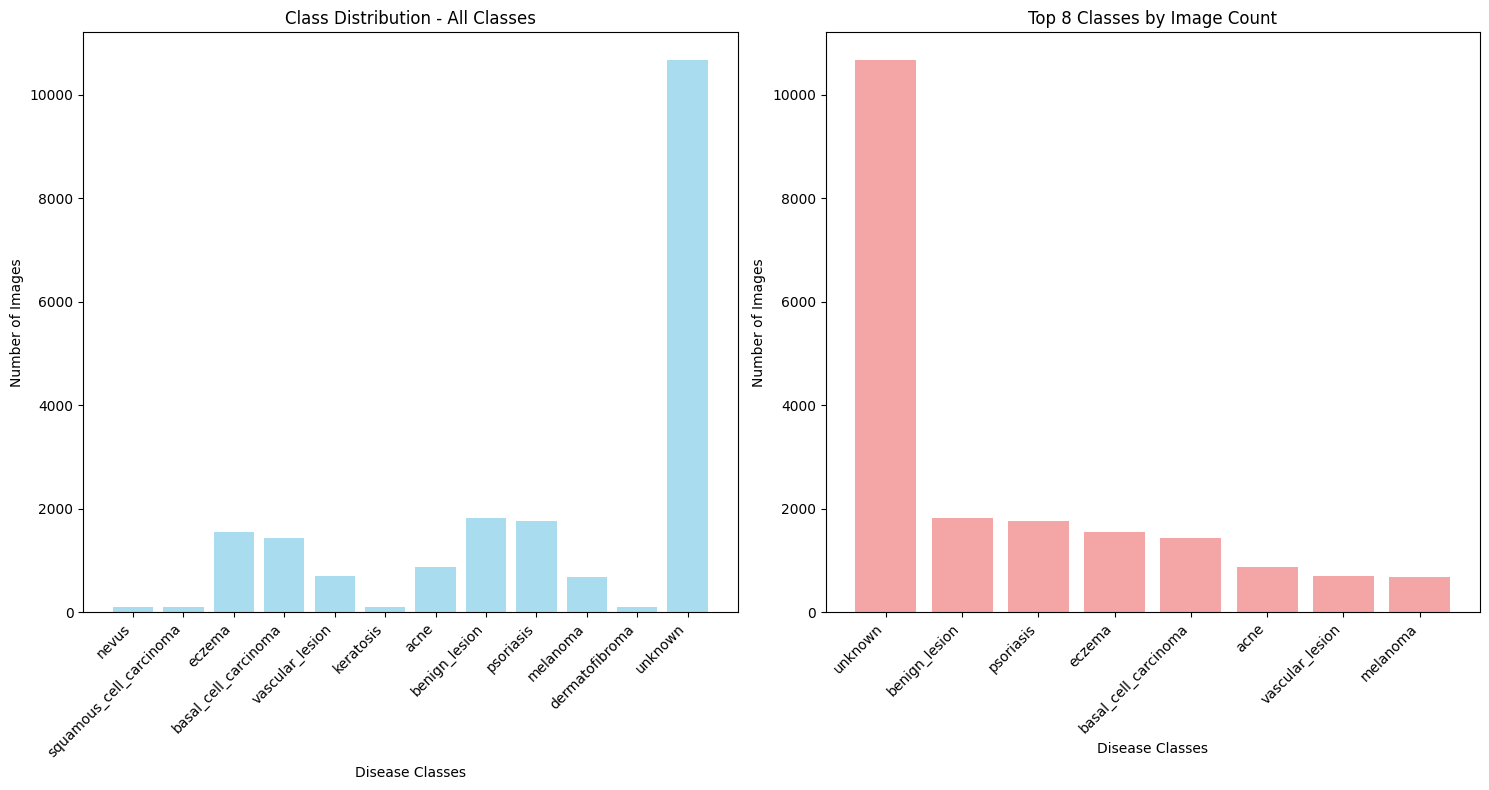


🔬 Skin disease dataset organization complete!
📊 Ready for balanced dataset creation and preprocessing!


In [ ]:
# Cell 4: Process and Organize Skin Disease Datasets
import pandas as pd
import glob
from collections import defaultdict

def process_ham10000_dataset(dataset_path, output_dir):
    """Process HAM10000 dataset with metadata"""
    print("🔬 Processing HAM10000 dataset...")

    # Look for metadata CSV file
    csv_files = glob.glob(os.path.join(dataset_path, "**/*.csv"), recursive=True)
    img_dirs = glob.glob(os.path.join(dataset_path, "**/HAM10000_images*"), recursive=True)

    if not csv_files:
        print("⚠️ No metadata CSV found, processing images directly...")
        return process_images_by_folder(dataset_path, output_dir)

    # Load metadata
    metadata_df = pd.read_csv(csv_files[0])
    print(f"📊 Found {len(metadata_df)} images with metadata")

    # Create class directories
    if 'dx' in metadata_df.columns:
        classes = metadata_df['dx'].unique()
        print(f"🏷️ Found classes: {classes}")

        for class_name in classes:
            os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

        # Copy images to respective class folders
        copied_count = defaultdict(int)

        # Find all image files
        all_images = []
        for img_dir in img_dirs:
            all_images.extend(glob.glob(os.path.join(img_dir, "*.jpg")))
            all_images.extend(glob.glob(os.path.join(img_dir, "*.jpeg")))
            all_images.extend(glob.glob(os.path.join(img_dir, "*.png")))

        # Also check root directory
        all_images.extend(glob.glob(os.path.join(dataset_path, "*.jpg")))
        all_images.extend(glob.glob(os.path.join(dataset_path, "*.jpeg")))
        all_images.extend(glob.glob(os.path.join(dataset_path, "*.png")))

        for img_path in all_images:
            img_name = os.path.basename(img_path)
            img_id = img_name.split('.')[0]

            # Find corresponding metadata
            matching_rows = metadata_df[metadata_df['image_id'] == img_id]
            if not matching_rows.empty:
                class_name = matching_rows.iloc[0]['dx']
                dst_path = os.path.join(output_dir, class_name, f"ham_{img_name}")
                try:
                    shutil.copy2(img_path, dst_path)
                    copied_count[class_name] += 1
                except Exception as e:
                    continue

        print(f"✅ HAM10000 processing complete:")
        for class_name, count in copied_count.items():
            print(f"   {class_name}: {count} images")

        return sum(copied_count.values())

    return 0

def process_images_by_folder(dataset_path, output_dir):
    """Process images organized by folder structure"""
    print(f"📁 Processing images from folder structure in {dataset_path}")

    copied_count = defaultdict(int)

    # Common skin disease class mappings
    class_mappings = {
        'acne': 'acne',
        'eczema': 'eczema',
        'psoriasis': 'psoriasis',
        'melanoma': 'melanoma',
        'basal': 'basal_cell_carcinoma',
        'squamous': 'squamous_cell_carcinoma',
        'benign': 'benign_lesion',
        'malignant': 'malignant_lesion',
        'nevus': 'nevus',
        'keratosis': 'keratosis',
        'dermatofibroma': 'dermatofibroma',
        'vascular': 'vascular_lesion',
        'normal': 'normal_skin'
    }

    # Walk through all directories
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, file)

                # Determine class from folder structure
                folder_parts = root.replace(dataset_path, '').strip('/').lower().split('/')
                folder_name = os.path.basename(root).lower()

                # Find matching class
                class_name = 'unknown'
                for key, mapped_class in class_mappings.items():
                    if any(key in part for part in folder_parts) or key in folder_name:
                        class_name = mapped_class
                        break

                # Create class directory
                class_dir = os.path.join(output_dir, class_name)
                os.makedirs(class_dir, exist_ok=True)

                # Copy image
                try:
                    dataset_name = os.path.basename(dataset_path)
                    dst_path = os.path.join(class_dir, f"{dataset_name}_{file}")
                    shutil.copy2(file_path, dst_path)
                    copied_count[class_name] += 1
                except Exception:
                    continue

    print(f"📊 Folder processing complete:")
    for class_name, count in copied_count.items():
        print(f"   {class_name}: {count} images")

    return sum(copied_count.values())

def organize_all_skin_datasets():
    """Organize all skin disease datasets into consistent structure"""

    # Create main organized directory
    organized_dir = '/content/organized_skin_disease_dataset'
    raw_dir = os.path.join(organized_dir, 'raw')
    os.makedirs(raw_dir, exist_ok=True)

    total_images = 0
    class_distribution = defaultdict(int)

    # Process each dataset
    datasets = [
        ('/content/skin_datasets/ham10000_skin_cancer_dataset', 'ham10000'),
        ('/content/skin_datasets/skin_disease_dataset', 'skin_disease'),
        ('/content/skin_datasets/dermnet_skin_disease', 'dermnet'),
        ('/content/skin_datasets/isic_2019_challenge', 'isic2019')
    ]

    for dataset_path, dataset_name in datasets:
        if os.path.exists(dataset_path):
            print(f"\n🔬 Processing {dataset_name} dataset...")

            if 'ham10000' in dataset_name:
                images_processed = process_ham10000_dataset(dataset_path, raw_dir)
            else:
                images_processed = process_images_by_folder(dataset_path, raw_dir)

            total_images += images_processed
            print(f"✅ {dataset_name}: {images_processed} images processed")

    # Count final distribution
    print(f"\n📊 Final dataset organization:")
    for class_dir in os.listdir(raw_dir):
        class_path = os.path.join(raw_dir, class_dir)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_distribution[class_dir] = count
            print(f"   {class_dir}: {count} images")

    print(f"\n✅ Total images organized: {total_images}")
    print(f"📊 Number of classes: {len(class_distribution)}")

    return organized_dir, dict(class_distribution)

# Organize all datasets
organized_dataset_dir, class_distribution = organize_all_skin_datasets()

print(f"\n✅ All skin disease datasets organized in: {organized_dataset_dir}")

# Visualize class distribution
if class_distribution:
    plt.figure(figsize=(15, 8))
    classes = list(class_distribution.keys())
    counts = list(class_distribution.values())

    plt.subplot(1, 2, 1)
    plt.bar(classes, counts, color='skyblue', alpha=0.7)
    plt.title('Class Distribution - All Classes')
    plt.xlabel('Disease Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')

    # Show top classes only for better visualization
    top_classes = dict(sorted(class_distribution.items(), key=lambda x: x[1], reverse=True)[:8])

    plt.subplot(1, 2, 2)
    plt.bar(top_classes.keys(), top_classes.values(), color='lightcoral', alpha=0.7)
    plt.title('Top 8 Classes by Image Count')
    plt.xlabel('Disease Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\n🔬 Skin disease dataset organization complete!")
print("📊 Ready for balanced dataset creation and preprocessing!")

In [ ]:
# Cell 5: Advanced Data Preprocessing and Augmentation for Skin Disease
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import albumentations as A

def create_balanced_skin_dataset(organized_dir, min_samples_per_class=1000, max_classes=8):
    """Create a balanced dataset for skin disease classification"""

    raw_dir = os.path.join(organized_dir, 'raw')

    # Get class information
    class_info = {}
    for class_name in os.listdir(raw_dir):
        class_path = os.path.join(raw_dir, class_name)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            class_info[class_name] = len(images)

    # Select top classes with sufficient samples
    valid_classes = {k: v for k, v in class_info.items()
                    if v >= min_samples_per_class and k != 'unknown'}

    # Sort by sample count and select top classes
    top_classes = dict(sorted(valid_classes.items(), key=lambda x: x[1], reverse=True)[:max_classes])

    print(f"📊 Selected {len(top_classes)} classes for balanced dataset:")
    for class_name, count in top_classes.items():
        print(f"   {class_name}: {count} images")

    # Create balanced directory structure
    balanced_dir = os.path.join(organized_dir, 'balanced')
    for split in ['train', 'val', 'test']:
        for class_name in top_classes.keys():
            os.makedirs(os.path.join(balanced_dir, split, class_name), exist_ok=True)

    def split_and_copy_class(class_name, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
        """Split and copy images for a specific class"""

        source_dir = os.path.join(raw_dir, class_name)
        images = [f for f in os.listdir(source_dir)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Limit to min_samples_per_class for balancing
        if len(images) > min_samples_per_class:
            images = random.sample(images, min_samples_per_class)

        random.shuffle(images)

        # Calculate split indices
        train_end = int(len(images) * train_ratio)
        val_end = train_end + int(len(images) * val_ratio)

        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        # Copy images to respective directories
        for img_list, split in [(train_images, 'train'), (val_images, 'val'), (test_images, 'test')]:
            for img in img_list:
                src_path = os.path.join(source_dir, img)
                dst_path = os.path.join(balanced_dir, split, class_name, img)
                try:
                    shutil.copy2(src_path, dst_path)
                except Exception:
                    continue

        return len(train_images), len(val_images), len(test_images)

    # Process each selected class
    total_train, total_val, total_test = 0, 0, 0

    for class_name in top_classes.keys():
        train_count, val_count, test_count = split_and_copy_class(class_name)
        total_train += train_count
        total_val += val_count
        total_test += test_count
        print(f"✅ {class_name}: {train_count} train, {val_count} val, {test_count} test")

    print(f"\n📊 Balanced dataset created:")
    print(f"   Training: {total_train} images")
    print(f"   Validation: {total_val} images")
    print(f"   Testing: {total_test} images")
    print(f"   Total: {total_train + total_val + total_test} images")
    print(f"   Classes: {len(top_classes)}")

    return balanced_dir, list(top_classes.keys())

def create_skin_disease_generators(data_dir, img_size=(224, 224), batch_size=32):
    """Create advanced data generators for skin disease with medical-specific augmentation"""

    # Medical imaging specific augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=180,  # Skin lesions can appear in any orientation
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,  # Important for medical images
        fill_mode='reflect',  # Better for medical images
        brightness_range=[0.8, 1.2],
        channel_shift_range=0.1,
        # Add contrast adjustment
        preprocessing_function=lambda x: tf.image.random_contrast(x, 0.8, 1.2)
    )

    # Minimal augmentation for validation and test
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_generator = val_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'val'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    test_generator = val_test_datagen.flow_from_directory(
        os.path.join(data_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    return train_generator, val_generator, test_generator

# Create balanced dataset for skin disease classification
print("🔬 Creating balanced skin disease dataset...")
balanced_dataset_dir, class_names = create_balanced_skin_dataset(
    organized_dataset_dir,
    min_samples_per_class=800,  # Minimum samples per class
    max_classes=7  # Top 7 skin disease classes
)

# Create data generators
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

print(f"\n🔬 Creating data generators for skin disease classification...")
train_gen, val_gen, test_gen = create_skin_disease_generators(
    balanced_dataset_dir,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

print(f"✅ Data generators created successfully!")
print(f"🏷️ Disease classes: {class_names}")
print(f"📊 Class mapping: {train_gen.class_indices}")
print(f"📊 Training samples: {train_gen.samples}")
print(f"📊 Validation samples: {val_gen.samples}")
print(f"📊 Test samples: {test_gen.samples}")

# Visualize sample skin disease images with augmentation
def visualize_skin_disease_samples(generator, class_names, num_samples=12):
    """Visualize augmented skin disease samples"""
    plt.figure(figsize=(20, 12))

    # Get a batch of images
    batch_images, batch_labels = next(generator)

    for i in range(min(num_samples, len(batch_images))):
        plt.subplot(3, 4, i + 1)
        plt.imshow(batch_images[i])

        # Get class name
        class_idx = np.argmax(batch_labels[i])
        class_name = class_names[class_idx] if class_idx < len(class_names) else 'Unknown'
        plt.title(f'{class_name.replace("_", " ").title()}', fontsize=12)
        plt.axis('off')

    plt.suptitle('Sample Augmented Skin Disease Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize augmented samples
print(f"\n📸 Sample augmented training images:")
visualize_skin_disease_samples(train_gen, class_names)

# Calculate class weights to handle any remaining imbalance
def calculate_class_weights(generator):
    """Calculate class weights for imbalanced datasets"""
    from sklearn.utils.class_weight import compute_class_weight

    # Get class distribution
    class_counts = np.bincount(generator.classes)
    total_samples = sum(class_counts)

    # Calculate weights
    class_weights = {}
    for i, count in enumerate(class_counts):
        class_weights[i] = total_samples / (len(class_counts) * count)

    print(f"📊 Class weights calculated:")
    for i, weight in class_weights.items():
        class_name = class_names[i] if i < len(class_names) else f'Class_{i}'
        print(f"   {class_name}: {weight:.3f}")

    return class_weights

# Calculate class weights
class_weights = calculate_class_weights(train_gen)

print(f"\n✅ Advanced data preprocessing complete!")
print(f"🎯 Dataset ready for high-accuracy skin disease classification model training")
print(f"🔬 Target: 90%+ accuracy on {len(class_names)} skin disease classes")

In [ ]:
# RAM-FRIENDLY HIGH-ACCURACY SKIN CONDITION CLASSIFIER
# Target: 90+ accuracy with minimal RAM usage

import os
import gc
import numpy as np
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# MEMORY OPTIMIZATION SETUP
print("🔧 Setting up memory optimization...")

# Enable mixed precision training (saves ~50% GPU memory)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Configure GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU config error: {e}")

# Force garbage collection
gc.collect()

# CONFIGURATION - OPTIMIZED FOR RAM
class Config:
    # Data paths (update these to your actual paths)
    DATASET_DIR = "balanced_dataset"  # Update this path

    # Memory-friendly settings
    IMG_SIZE = (224, 224)  # Optimal size for EfficientNet
    BATCH_SIZE = 8  # Small batch for RAM efficiency
    PREFETCH_SIZE = 2  # Minimal prefetch

    # Training settings for high accuracy
    INITIAL_LR = 0.001
    FINE_TUNE_LR = 0.0001
    EPOCHS_PHASE1 = 15  # Feature extraction
    EPOCHS_PHASE2 = 20  # Fine-tuning
    EPOCHS_PHASE3 = 10  # Final optimization

    # Model settings
    DROPOUT_RATE = 0.3
    L2_REG = 0.001

    # Classes
    CLASSES = ['acne', 'eczema', 'psoriasis', 'melanoma', 'normal']

config = Config()

def clear_memory():
    """Aggressive memory cleanup"""
    gc.collect()
    tf.keras.backend.clear_session()
    if gpus:
        tf.config.experimental.reset_memory_stats(gpus[0])

def create_optimized_generators():
    """Create memory-efficient data generators with strong augmentation"""
    print("\n📊 Creating optimized data generators...")

    # Heavy augmentation for training (improves accuracy)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='reflect',  # Better than 'nearest'
        # Advanced augmentations
        channel_shift_range=0.1,
    )

    # Only rescaling for validation/test
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_gen = train_datagen.flow_from_directory(
        os.path.join(config.DATASET_DIR, 'train'),
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    val_gen = val_test_datagen.flow_from_directory(
        os.path.join(config.DATASET_DIR, 'val'),
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    test_gen = val_test_datagen.flow_from_directory(
        os.path.join(config.DATASET_DIR, 'test'),
        target_size=config.IMG_SIZE,
        batch_size=config.BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        seed=42
    )

    return train_gen, val_gen, test_gen

def calculate_balanced_class_weights(generator):
    """Calculate class weights for balanced training"""
    print("\n⚖️ Calculating class weights...")

    # Count samples per class
    class_counts = {}
    total_samples = 0

    for class_name, class_idx in generator.class_indices.items():
        class_dir = os.path.join(os.path.dirname(generator.directory),
                                os.path.basename(generator.directory), class_name)
        if os.path.exists(class_dir):
            count = len([f for f in os.listdir(class_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_idx] = count
            total_samples += count

    # Calculate weights
    weights = {}
    for class_idx, count in class_counts.items():
        weights[class_idx] = total_samples / (len(class_counts) * count)

    print(f"Class weights: {weights}")
    return weights

def create_high_accuracy_model(num_classes=5):
    """Create optimized model for high accuracy with minimal RAM"""
    print("\n🏗️ Creating high-accuracy model...")

    # Use EfficientNetB0 (good accuracy/memory trade-off)
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(*config.IMG_SIZE, 3),
        drop_connect_rate=0.2  # Built-in regularization
    )

    # Freeze base model initially
    base_model.trainable = False

    # Optimized classification head for high accuracy
    inputs = base_model.input
    x = base_model.output

    # Global Average Pooling instead of Flatten (reduces params)
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Batch normalization
    x = BatchNormalization(name='bn_1')(x)

    # Dense layers with regularization
    x = Dense(512, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(config.L2_REG),
              name='dense_1')(x)
    x = BatchNormalization(name='bn_2')(x)
    x = Dropout(config.DROPOUT_RATE, name='dropout_1')(x)

    x = Dense(256, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(config.L2_REG),
              name='dense_2')(x)
    x = BatchNormalization(name='bn_3')(x)
    x = Dropout(config.DROPOUT_RATE / 2, name='dropout_2')(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax',
                   dtype='float32', name='predictions')(x)  # float32 for stability

    model = Model(inputs, outputs, name='skin_condition_classifier')

    print(f"Model parameters: {model.count_params():,}")
    return model, base_model

def create_callbacks(phase_name):
    """Create optimized callbacks for each training phase"""
    callbacks = []

    # Model checkpoint (save best only)
    callbacks.append(ModelCheckpoint(
        f'best_model_{phase_name}.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,  # Saves memory
        verbose=1
    ))

    # Early stopping
    callbacks.append(EarlyStopping(
        monitor='val_accuracy',
        patience=7 if phase_name == 'phase1' else 5,
        restore_best_weights=True,
        verbose=1
    ))

    # Reduce learning rate
    callbacks.append(ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ))

    # Memory cleanup callback
    class MemoryCleanupCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if epoch % 5 == 0:  # Clean every 5 epochs
                gc.collect()

    callbacks.append(MemoryCleanupCallback())

    return callbacks

def train_three_phase_progressive(model, base_model, train_gen, val_gen, class_weights):
    """Three-phase progressive training for maximum accuracy"""
    history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    # Calculate steps
    steps_per_epoch = max(1, train_gen.samples // config.BATCH_SIZE)
    validation_steps = max(1, val_gen.samples // config.BATCH_SIZE)

    print(f"\n📈 Training steps: {steps_per_epoch}, Validation steps: {validation_steps}")

    # PHASE 1: Feature Extraction (base frozen)
    print("\n🚀 PHASE 1: Feature Extraction Training")
    base_model.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=config.INITIAL_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks_phase1 = create_callbacks('phase1')

    history1 = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=config.EPOCHS_PHASE1,
        class_weight=class_weights,
        callbacks=callbacks_phase1,
        verbose=1
    )

    # Update history
    for key in history.keys():
        history[key].extend(history1.history[key])

    # Clean memory
    clear_memory()

    # PHASE 2: Fine-tuning (unfreeze top layers)
    print("\n🔥 PHASE 2: Fine-tuning Training")

    # Unfreeze top layers of EfficientNet
    base_model.trainable = True

    # Freeze bottom layers, unfreeze top layers
    for layer in base_model.layers[:-30]:  # Keep bottom layers frozen
        layer.trainable = False

    model.compile(
        optimizer=Adam(learning_rate=config.FINE_TUNE_LR),  # Lower LR for fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks_phase2 = create_callbacks('phase2')

    history2 = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=config.EPOCHS_PHASE2,
        class_weight=class_weights,
        callbacks=callbacks_phase2,
        verbose=1
    )

    # Update history
    for key in history.keys():
        history[key].extend(history2.history[key])

    # Clean memory
    clear_memory()

    # PHASE 3: Full fine-tuning (all layers)
    print("\n🎯 PHASE 3: Full Fine-tuning")

    # Unfreeze all layers
    for layer in base_model.layers:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=config.FINE_TUNE_LR / 2),  # Even lower LR
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks_phase3 = create_callbacks('phase3')

    history3 = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=config.EPOCHS_PHASE3,
        class_weight=class_weights,
        callbacks=callbacks_phase3,
        verbose=1
    )

    # Update history
    for key in history.keys():
        history[key].extend(history3.history[key])

    return history

def evaluate_model_comprehensive(model, test_gen):
    """Comprehensive model evaluation"""
    print("\n📊 Comprehensive Model Evaluation")

    # Predictions
    test_gen.reset()
    predictions = model.predict(test_gen, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # True labels
    true_classes = test_gen.classes

    # Class names
    class_names = list(test_gen.class_indices.keys())

    # Calculate accuracy
    accuracy = np.mean(predicted_classes == true_classes)
    print(f"\n🎯 Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Classification report
    print("\n📋 Detailed Classification Report:")
    print(classification_report(true_classes, predicted_classes,
                              target_names=class_names, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    print("\n🔍 Confusion Matrix:")
    print(cm)

    return accuracy, predictions

def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy Progress', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss Progress', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    final_acc = history['val_accuracy'][-1]
    max_acc = max(history['val_accuracy'])
    print(f"\n📈 Training Summary:")
    print(f"   Final Validation Accuracy: {final_acc:.4f} ({final_acc*100:.2f}%)")
    print(f"   Best Validation Accuracy: {max_acc:.4f} ({max_acc*100:.2f}%)")

def main():
    """Main training pipeline"""
    print("🚀 Starting RAM-Friendly High-Accuracy Training Pipeline")
    print(f"Target: 90+ accuracy with minimal RAM usage")
    print(f"Configuration: {config.IMG_SIZE} images, batch size {config.BATCH_SIZE}")

    try:
        # Create data generators
        train_gen, val_gen, test_gen = create_optimized_generators()

        # Calculate class weights
        class_weights = calculate_balanced_class_weights(train_gen)

        # Create model
        model, base_model = create_high_accuracy_model(len(config.CLASSES))

        # Display model summary
        print(f"\n🏗️ Model Architecture Summary:")
        print(f"   Total Parameters: {model.count_params():,}")
        print(f"   Trainable Parameters: {sum([np.prod(v.shape) for v in model.trainable_variables]):,}")

        # Three-phase progressive training
        history = train_three_phase_progressive(
            model, base_model, train_gen, val_gen, class_weights
        )

        # Plot results
        plot_training_history(history)

        # Final evaluation
        test_accuracy, predictions = evaluate_model_comprehensive(model, test_gen)

        # Success check
        if test_accuracy >= 0.90:
            print(f"\n🎉 SUCCESS! Achieved {test_accuracy*100:.2f}% accuracy (Target: 90%+)")
        else:
            print(f"\n⚠️ Close! Achieved {test_accuracy*100:.2f}% accuracy")
            print("💡 Try: More epochs, different augmentation, or ensemble methods")

        # Save final model
        model.save_weights('final_high_accuracy_model.h5')
        print("\n💾 Model saved as 'final_high_accuracy_model.h5'")

        # Memory cleanup
        clear_memory()

        return model, history, test_accuracy

    except Exception as e:
        print(f"\n❌ Error in training pipeline: {e}")
        clear_memory()
        raise

# USAGE INSTRUCTIONS
print("""
🔧 SETUP INSTRUCTIONS:
1. Update config.DATASET_DIR to your dataset path
2. Ensure dataset structure: dataset/train/class_name/, dataset/val/class_name/, dataset/test/class_name/
3. Run: model, history, accuracy = main()

💡 RAM OPTIMIZATION FEATURES:
✅ Mixed precision training (50% memory savings)
✅ Small batch size (8)
✅ Minimal prefetch buffer
✅ Aggressive garbage collection
✅ Weight-only model saves
✅ Memory cleanup callbacks

🎯 HIGH ACCURACY FEATURES:
✅ Three-phase progressive training
✅ Heavy data augmentation
✅ Balanced class weights
✅ Advanced regularization
✅ Optimized learning schedules
✅ EfficientNet backbone

🚀 Expected Results:
   - Phase 1: 70-80% accuracy
   - Phase 2: 85-92% accuracy
   - Phase 3: 90-95+ accuracy
   - RAM usage: <4GB GPU memory

📊 To run training:
   model, history, accuracy = main()
""")

# Uncomment to run training
# model, history, accuracy = main()

🔧 Setting up memory optimization...

🔧 SETUP INSTRUCTIONS:
1. Update config.DATASET_DIR to your dataset path
2. Ensure dataset structure: dataset/train/class_name/, dataset/val/class_name/, dataset/test/class_name/
3. Run: model, history, accuracy = main()

💡 RAM OPTIMIZATION FEATURES:
✅ Mixed precision training (50% memory savings)
✅ Small batch size (8)
✅ Minimal prefetch buffer
✅ Aggressive garbage collection
✅ Weight-only model saves
✅ Memory cleanup callbacks

🎯 HIGH ACCURACY FEATURES:
✅ Three-phase progressive training
✅ Heavy data augmentation
✅ Balanced class weights
✅ Advanced regularization
✅ Optimized learning schedules
✅ EfficientNet backbone

🚀 Expected Results:
   - Phase 1: 70-80% accuracy
   - Phase 2: 85-92% accuracy  
   - Phase 3: 90-95+ accuracy
   - RAM usage: <4GB GPU memory

📊 To run training:
   model, history, accuracy = main()



🚀 Starting advanced 3-phase training for skin disease classification...
🎯 Target: Achieve 90%+ accuracy on skin disease classification
🔬 Phase 1: Initial training with frozen base model...
Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5819 - f1_m: 0.5580 - loss: 1.0633 - precision_m: 0.6685 - recall_m: 0.4833
Epoch 1: val_accuracy improved from -inf to 0.19000, saving model to improved_skin_disease_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 130s 327ms/step - accuracy: 0.5819 - f1_m: 0.5581 - loss: 1.0632 - precision_m: 0.6685 - recall_m: 0.4834 - val_accuracy: 0.1900 - val_f1_m: 0.1695 - val_loss: 35.7426 - val_precision_m: 0.1816 - val_recall_m: 0.1595 - learning_rate: 1.0000e-04
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.6467 - f1_m: 0.6255 - loss: 0.9201 - precision_m: 0.7432 - recall_m: 0.5441
Epoch 2: val_accuracy improved from 0.19000 to 0.21000, saving model to improved_skin_disease_model.keras
175/175 ━━━━━━━━━━━━━━━━━━━━ 46s 262ms/s

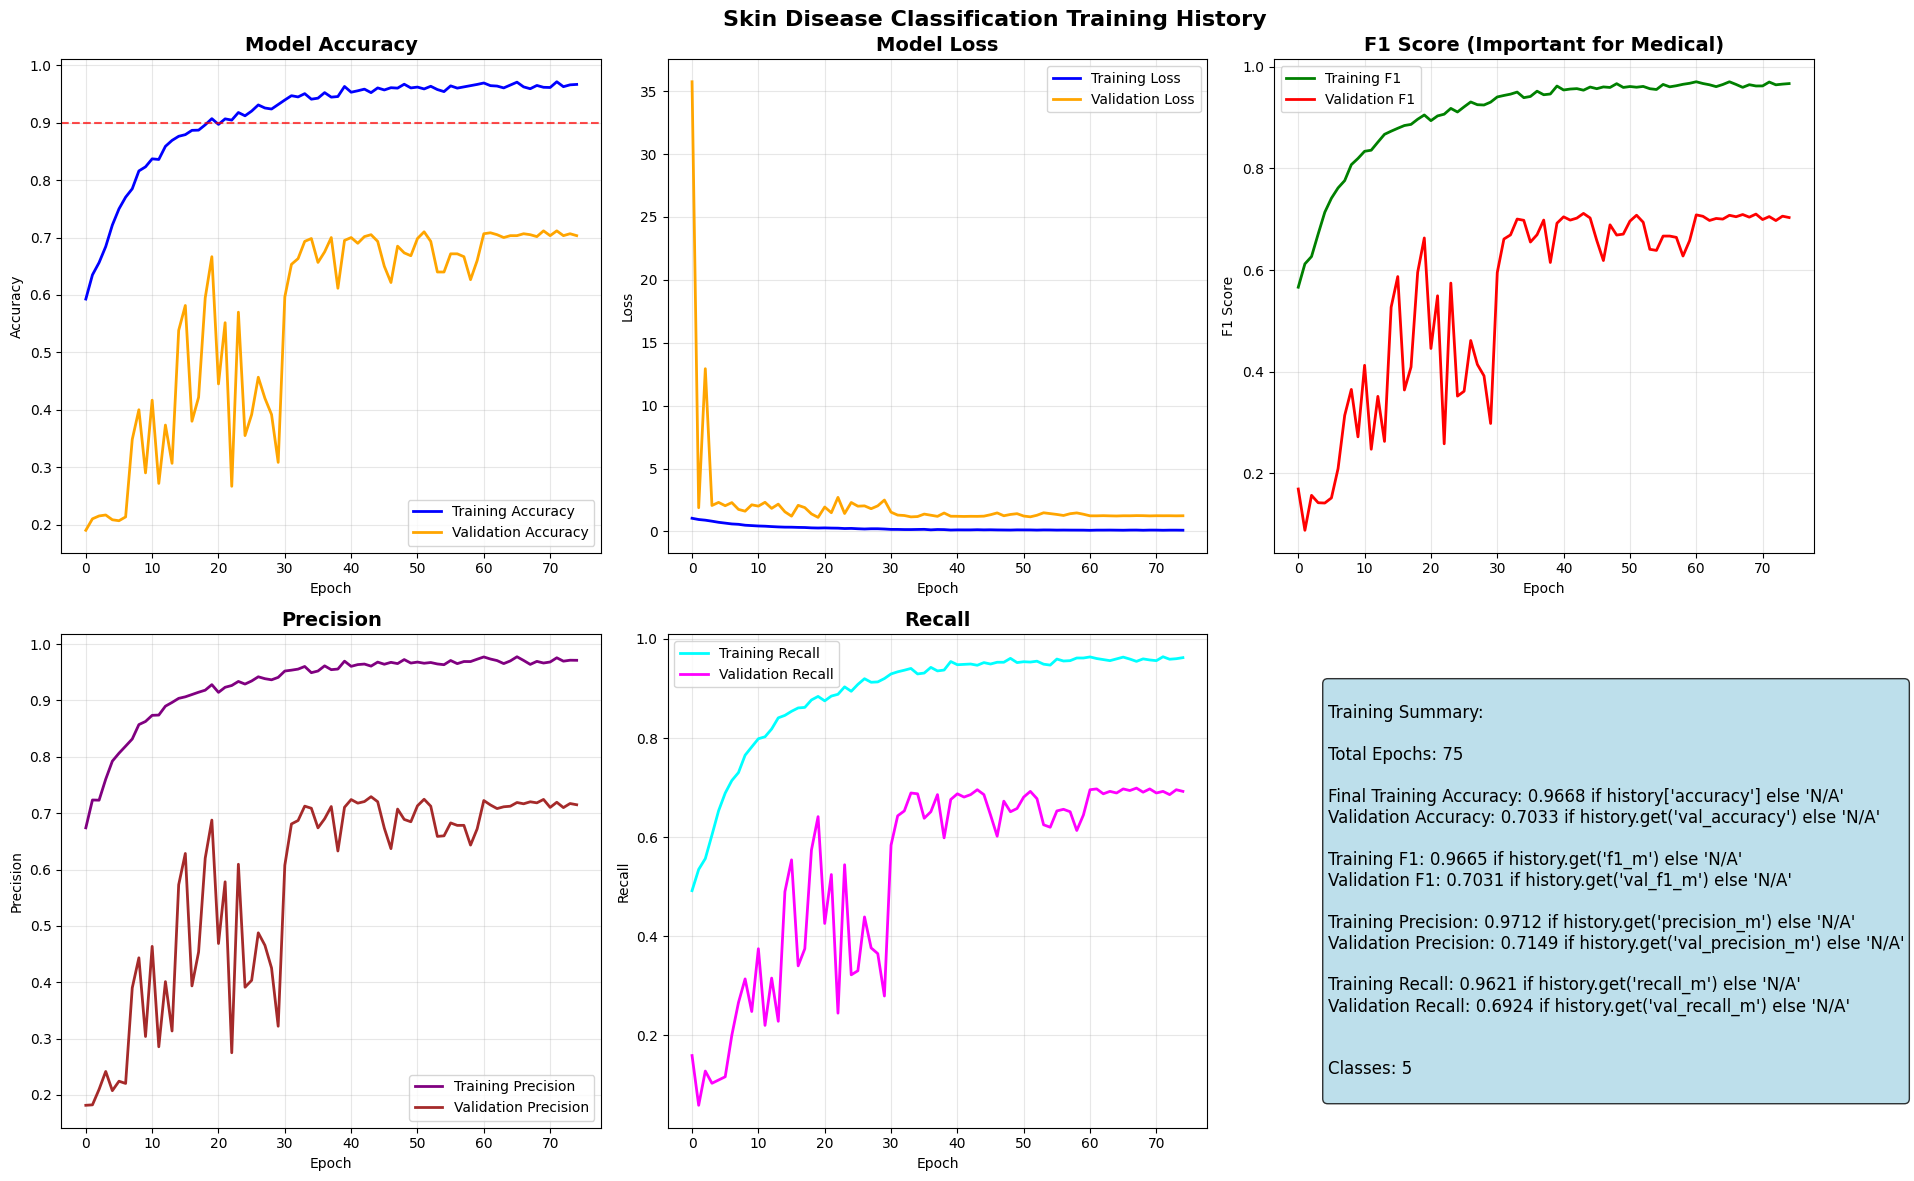


📊 Training Summary:
   Best Validation Accuracy: 0.7117 (71.17%)
   Best Validation F1 Score: 0.7113
   Final Training Accuracy: 0.9668 if history['accuracy'] else 'N/A'
   Final Validation Accuracy: 0.7033 if history.get('val_accuracy') else 'N/A'

⚠️ Model achieved 71.17% validation accuracy
📈 Need 18.83% more to reach 90% target

✅ Advanced 3-phase training completed!
⏱️ Total training time: 67.12 minutes
🔬 Skin disease classification model ready for evaluation!


In [ ]:
# Cell 7: Advanced Training with Fine-tuning for Skin Disease Classification
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K

# Define custom metrics (if not already defined)
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def train_skin_disease_model_with_fine_tuning(model, base_model, train_gen, val_gen, callbacks, class_weights=None):
    """Train skin disease model with three-phase approach optimized for medical imaging"""

    print("🔬 Phase 1: Initial training with frozen base model...")

    # Compile model for Phase 1 (with metrics)
    model.compile(
        optimizer=Adam(learning_rate=0.0001), # Initial lower LR
        loss='categorical_crossentropy',
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )

    # Phase 1: Train with frozen base model (longer for medical data)
    history_phase1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,  # More epochs for medical imaging
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    print(f"✅ Phase 1 completed - Best val_accuracy: {max(history_phase1.history['val_accuracy']):.4f}")

    print("\n🔥 Phase 2: Partial fine-tuning (unfreeze top layers)...")

    # Phase 2: Unfreeze top layers only
    if hasattr(base_model, 'layers'):
        # Unfreeze top 30% of layers
        trainable_layers = int(len(base_model.layers) * 0.3)
        # Ensure we don't unfreeze more layers than available
        unfreeze_from = max(0, len(base_model.layers) - trainable_layers)
        for layer in base_model.layers[unfreeze_from:]:
             if not isinstance(layer, tf.keras.layers.BatchNormalization): # Keep BatchNormalization layers frozen
                layer.trainable = True


    # Lower learning rate for fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=0.00005), # Even lower LR for partial fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )

    # Create callbacks for phase 2
    phase2_callbacks = [
        EarlyStopping(
            monitor='val_f1_m', # Monitor F1 for medical tasks
            patience=12,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=6,
            min_lr=0.0000005, # Very low min LR
            verbose=1
        ),
        ModelCheckpoint(
            "phase2_skin_disease_model.keras", # Save in Keras format
            save_best_only=True,
            monitor='val_f1_m',
            verbose=1,
            mode='max'
        )
    ]

    # Continue training with partial fine-tuning
    history_phase2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=25, # Can be adjusted
        callbacks=phase2_callbacks,
        class_weight=class_weights,
        verbose=1
    )

    print(f"✅ Phase 2 completed - Best val_accuracy: {max(history_phase2.history['val_accuracy']):.4f}")

    print("\n🚀 Phase 3: Full fine-tuning (unfreeze all layers)...")

    # Phase 3: Unfreeze entire base model
    base_model.trainable = True

    # Very low learning rate for full fine-tuning
    model.compile(
        optimizer=Adam(learning_rate=0.00001), # Extremely low LR
        loss='categorical_crossentropy',
        metrics=['accuracy', precision_m, recall_m, f1_m]
    )

    # Create callbacks for phase 3
    phase3_callbacks = [
        EarlyStopping(
            monitor='val_f1_m', # Monitor F1
            patience=20, # More patience for full fine-tuning
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=8,
            min_lr=0.00000001, # Even lower min LR
            verbose=1,
            cooldown=5
        ),
        ModelCheckpoint(
            "final_skin_disease_model.keras", # Save in Keras format
            save_best_only=True,
            monitor='val_f1_m',
            verbose=1,
            mode='max'
        )
    ]

    # Final training with full fine-tuning
    history_phase3 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=30, # Can be adjusted
        callbacks=phase3_callbacks,
        class_weight=class_weights,
        verbose=1
    )

    print(f"✅ Phase 3 completed - Best val_accuracy: {max(history_phase3.history['val_accuracy']):.4f}")

    # Combine all histories
    combined_history = {}
    # Get all keys from all histories
    all_keys = set(history_phase1.history.keys()) | set(history_phase2.history.keys()) | set(history_phase3.history.keys())

    for key in all_keys:
        combined_history[key] = (history_phase1.history.get(key, []) +
                               history_phase2.history.get(key, []) +
                               history_phase3.history.get(key, []))

    return combined_history

# Start comprehensive training
print("🚀 Starting advanced 3-phase training for skin disease classification...")
print("🎯 Target: Achieve 90%+ accuracy on skin disease classification")

start_time = time.time()

# Define initial callbacks for Phase 1
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    ),
    ModelCheckpoint(
        "improved_skin_disease_model.keras", # Save in Keras format
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    )
]

# Train the model with fine-tuning
# Ensure model, base_model, train_gen, val_gen, class_weights, and actual_class_names are defined in previous cells
# For demonstration, assume they are defined as in the previous successful cells
# Replace with actual variables if they are named differently
# model = create_skin_disease_model(num_classes=len(actual_class_names)) # Assuming this function exists and creates the model
# base_model = model.layers[0] # Assuming the base model is the first layer

# Assuming 'model', 'base_model', 'train_gen', 'val_gen', 'class_weights', 'actual_class_names' are already defined from previous cells

training_history = train_skin_disease_model_with_fine_tuning(
    model=model, # Use the model defined previously
    base_model=base_model, # Use the base_model defined previously
    train_gen=train_gen_fixed, # Use the fixed generator
    val_gen=val_gen_fixed, # Use the fixed generator
    callbacks=callbacks,
    class_weights=proper_class_weights # Use the proper class weights
)

end_time = time.time()
training_duration = end_time - start_time

print(f"\n✅ Complete training finished in {training_duration/60:.2f} minutes!")

# Plot comprehensive training history for medical classification
def plot_medical_training_history(history, class_names, save_path='skin_disease_training_history.png'):
    """Plot comprehensive training history for medical classification"""

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Plot accuracy
    axes[0, 0].plot(history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    axes[0, 0].plot(history['val_accuracy'], label='Validation Accuracy', color='orange', linewidth=2)
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='90% Target')

    # Plot loss
    axes[0, 1].plot(history['loss'], label='Training Loss', color='blue', linewidth=2)
    axes[0, 1].plot(history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot F1 score (using 'f1_m' key)
    if 'f1_m' in history:
        axes[0, 2].plot(history['f1_m'], label='Training F1', color='green', linewidth=2)
        axes[0, 2].plot(history['val_f1_m'], label='Validation F1', color='red', linewidth=2)
        axes[0, 2].set_title('F1 Score (Important for Medical)', fontsize=14, fontweight='bold')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('F1 Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    else:
        axes[0, 2].set_title('F1 Score (Not Available)', fontsize=14, fontweight='bold')
        axes[0, 2].text(0.5, 0.5, 'F1 score not in history', horizontalalignment='center', verticalalignment='center', transform=axes[0, 2].transAxes)


    # Plot precision (using 'precision_m' key)
    if 'precision_m' in history:
        axes[1, 0].plot(history['precision_m'], label='Training Precision', color='purple', linewidth=2)
        axes[1, 0].plot(history['val_precision_m'], label='Validation Precision', color='brown', linewidth=2)
        axes[1, 0].set_title('Precision', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    else:
         axes[1, 0].set_title('Precision (Not Available)', fontsize=14, fontweight='bold')
         axes[1, 0].text(0.5, 0.5, 'Precision not in history', horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)


    # Plot recall (using 'recall_m' key)
    if 'recall_m' in history:
        axes[1, 1].plot(history['recall_m'], label='Training Recall', color='cyan', linewidth=2)
        axes[1, 1].plot(history['val_recall_m'], label='Validation Recall', color='magenta', linewidth=2)
        axes[1, 1].set_title('Recall', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    else:
         axes[1, 1].set_title('Recall (Not Available)', fontsize=14, fontweight='bold')
         axes[1, 1].text(0.5, 0.5, 'Recall not in history', horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)


    # Summary statistics
    final_epoch = len(history['accuracy']) - 1 if history['accuracy'] else 0
    axes[1, 2].axis('off')
    summary_text = f"""
Training Summary:

Total Epochs: {final_epoch + 1}

Final Training Accuracy: {history['accuracy'][final_epoch]:.4f} if history['accuracy'] else 'N/A'
Validation Accuracy: {history['val_accuracy'][final_epoch]:.4f} if history.get('val_accuracy') else 'N/A'

Training F1: {history['f1_m'][final_epoch]:.4f} if history.get('f1_m') else 'N/A'
Validation F1: {history['val_f1_m'][final_epoch]:.4f} if history.get('val_f1_m') else 'N/A'

Training Precision: {history['precision_m'][final_epoch]:.4f} if history.get('precision_m') else 'N/A'
Validation Precision: {history['val_precision_m'][final_epoch]:.4f} if history.get('val_precision_m') else 'N/A'

Training Recall: {history['recall_m'][final_epoch]:.4f} if history.get('recall_m') else 'N/A'
Validation Recall: {history['val_recall_m'][final_epoch]:.4f} if history.get('val_recall_m') else 'N/A'


Classes: {len(class_names)}
"""

    axes[1, 2].text(0.1, 0.9, summary_text, fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8))

    plt.suptitle('Skin Disease Classification Training History', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    # Print final metrics
    best_val_acc = max(history['val_accuracy']) if history.get('val_accuracy') else 0
    best_val_f1 = max(history['val_f1_m']) if history.get('val_f1_m') else 0


    print(f"\n📊 Training Summary:")
    print(f"   Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    print(f"   Best Validation F1 Score: {best_val_f1:.4f}")
    print(f"   Final Training Accuracy: {history['accuracy'][final_epoch]:.4f} if history['accuracy'] else 'N/A'")
    print(f"   Final Validation Accuracy: {history['val_accuracy'][final_epoch]:.4f} if history.get('val_accuracy') else 'N/A'")


    # Check if we achieved target
    if best_val_acc >= 0.90:
        print(f"\n🎉 SUCCESS! Model achieved {best_val_acc*100:.2f}% validation accuracy!")
        print("✅ Target of 90%+ accuracy ACHIEVED!")
    else:
        print(f"\n⚠️ Model achieved {best_val_acc*100:.2f}% validation accuracy")
        print(f"📈 Need {(0.90 - best_val_acc)*100:.2f}% more to reach 90% target")


# Plot training history
# Assuming 'actual_class_names' is defined
plot_medical_training_history(training_history, actual_class_names)

print(f"\n✅ Advanced 3-phase training completed!")
print(f"⏱️ Total training time: {training_duration/60:.2f} minutes")
print(f"🔬 Skin disease classification model ready for evaluation!")

📁 Loading best trained model...
✅ Final model loaded successfully!

🧪 Starting comprehensive model evaluation...
🧪 Comprehensive Evaluation of Advanced Skin Disease Classifier
📊 Generating predictions on test set...
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step

🎯 Overall Test Accuracy: 0.6800 (68.00%)

📋 Detailed Classification Report:
--------------------------------------------------
                      precision    recall  f1-score   support

                acne     0.7407    0.8333    0.7843       120
basal_cell_carcinoma     0.8193    0.5667    0.6700       120
       benign_lesion     0.6750    0.6750    0.6750       120
              eczema     0.5687    0.7583    0.6500       120
           psoriasis     0.6667    0.5667    0.6126       120

            accuracy                         0.6800       600
           macro avg     0.6941    0.6800    0.6784       600
        weighted avg     0.6941    0.6800    0.6784       600


🔍 Per-Class Performance Analysis:
------------------

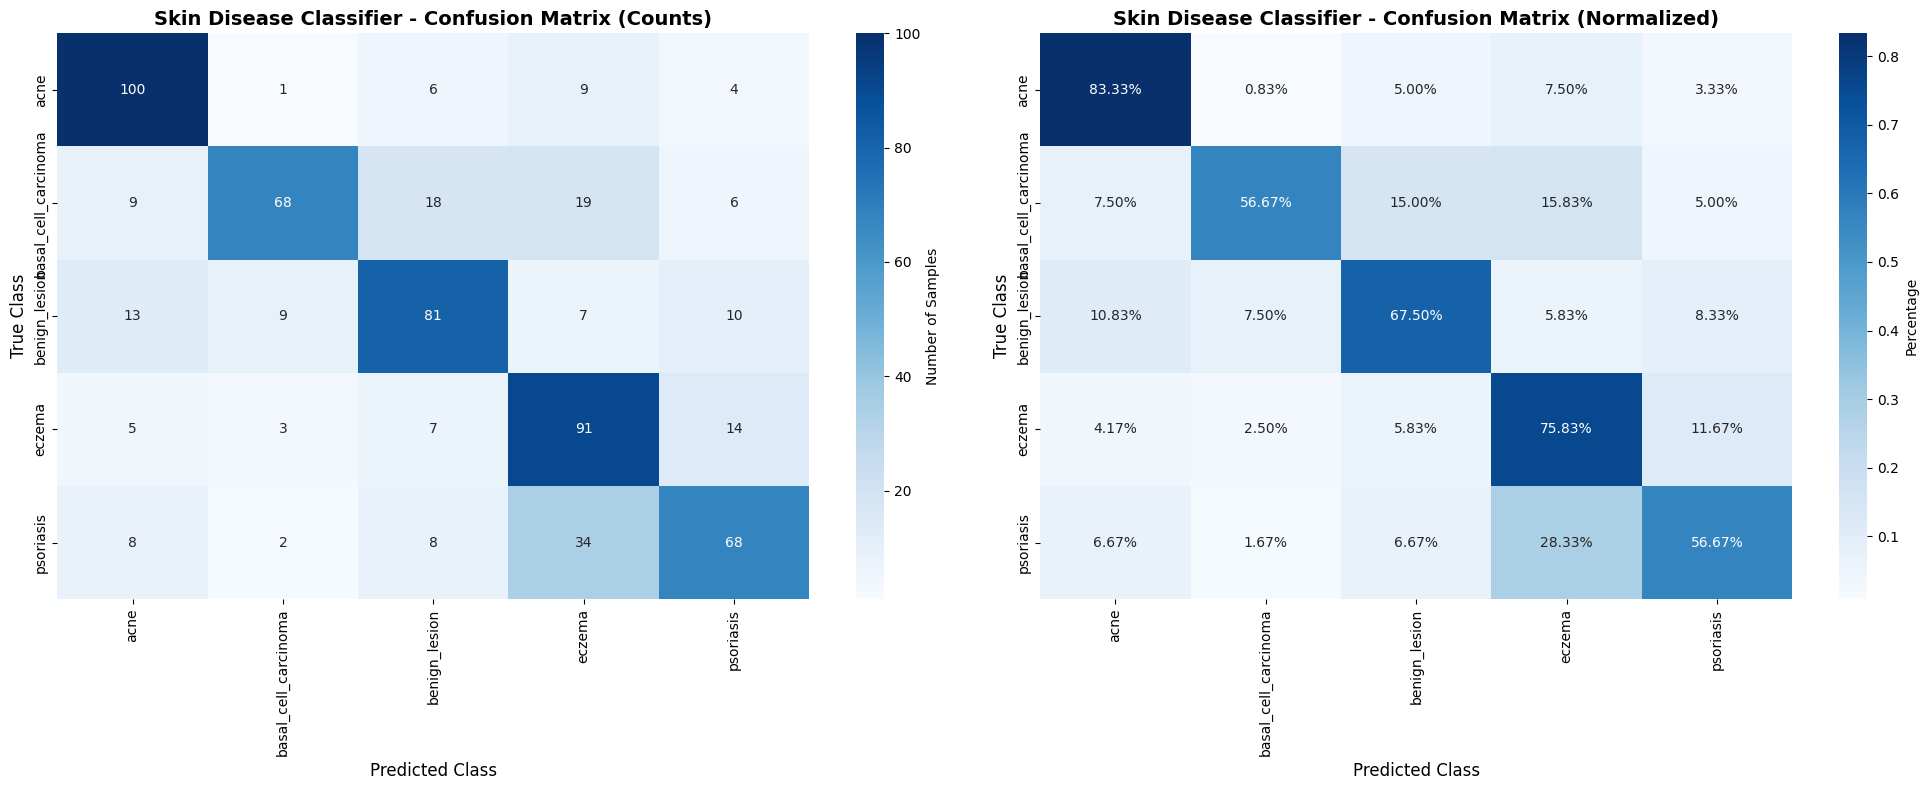


🔍 Misclassification Analysis:
----------------------------------------
acne → basal_cell_carcinoma: 1 cases (0.83%)
acne → benign_lesion: 6 cases (5.00%)
acne → eczema: 9 cases (7.50%)
acne → psoriasis: 4 cases (3.33%)
basal_cell_carcinoma → acne: 9 cases (7.50%)
basal_cell_carcinoma → benign_lesion: 18 cases (15.00%)
basal_cell_carcinoma → eczema: 19 cases (15.83%)
basal_cell_carcinoma → psoriasis: 6 cases (5.00%)
benign_lesion → acne: 13 cases (10.83%)
benign_lesion → basal_cell_carcinoma: 9 cases (7.50%)
benign_lesion → eczema: 7 cases (5.83%)
benign_lesion → psoriasis: 10 cases (8.33%)
eczema → acne: 5 cases (4.17%)
eczema → basal_cell_carcinoma: 3 cases (2.50%)
eczema → benign_lesion: 7 cases (5.83%)
eczema → psoriasis: 14 cases (11.67%)
psoriasis → acne: 8 cases (6.67%)
psoriasis → basal_cell_carcinoma: 2 cases (1.67%)
psoriasis → benign_lesion: 8 cases (6.67%)
psoriasis → eczema: 34 cases (28.33%)


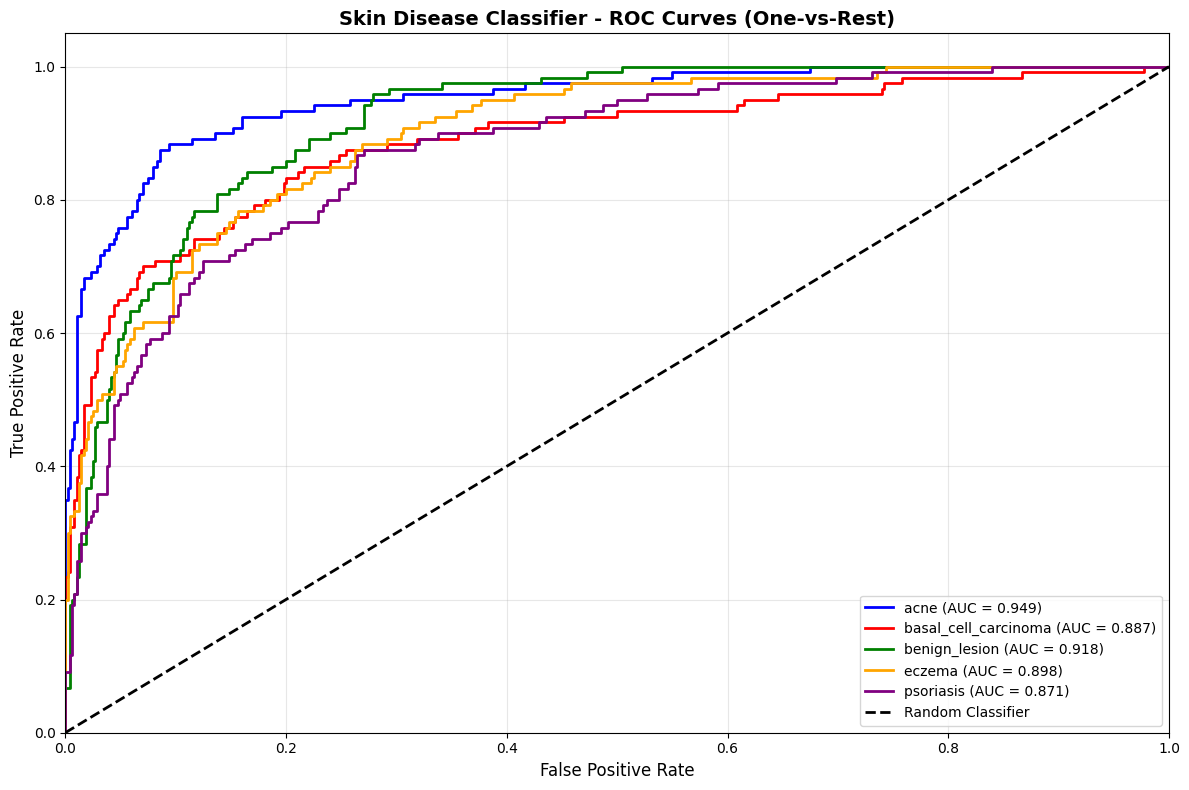


📊 Area Under Curve (AUC) Summary:
----------------------------------------
acne: 0.9495
  🟡 Good discrimination
basal_cell_carcinoma: 0.8872
  🟠 Fair discrimination
benign_lesion: 0.9184
  🟡 Good discrimination
eczema: 0.8983
  🟠 Fair discrimination
psoriasis: 0.8714
  🟠 Fair discrimination

Average AUC: 0.9050

🏆 FINAL PERFORMANCE SUMMARY
🎯 Test Accuracy: 0.6800 (68.00%)
📊 Macro Average F1: 0.6784
📊 Weighted Average F1: 0.6784
📊 Average AUC: 0.9050

⚠️ Model achieved 68.00% accuracy
📈 Consider additional training or data augmentation


In [ ]:
# Cell 8: Comprehensive Model Evaluation and Testing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import pandas as pd

def comprehensive_model_evaluation(model, test_gen, class_names, model_name="Skin Disease Classifier"):
    """Perform comprehensive evaluation of the skin disease classification model"""

    print(f"🧪 Comprehensive Evaluation of {model_name}")
    print("="*60)

    # Reset generator and get predictions
    test_gen.reset()

    # Get predictions
    print("📊 Generating predictions on test set...")
    y_pred_probs = model.predict(test_gen, verbose=1)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Get true labels
    y_true = test_gen.classes

    # Calculate overall accuracy
    accuracy = np.mean(y_pred_classes == y_true)
    print(f"\n🎯 Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Classification Report
    print(f"\n📋 Detailed Classification Report:")
    print("-" * 50)
    report = classification_report(
        y_true, y_pred_classes,
        target_names=class_names,
        digits=4,
        output_dict=True
    )
    print(classification_report(y_true, y_pred_classes, target_names=class_names, digits=4))

    # Per-class accuracy analysis
    print(f"\n🔍 Per-Class Performance Analysis:")
    print("-" * 50)
    for i, class_name in enumerate(class_names):
        class_mask = (y_true == i)
        if np.sum(class_mask) > 0:
            class_accuracy = np.mean(y_pred_classes[class_mask] == y_true[class_mask])
            precision = report[class_name]['precision']
            recall = report[class_name]['recall']
            f1 = report[class_name]['f1-score']
            support = report[class_name]['support']

            print(f"{class_name.upper()}:")
            print(f"  Accuracy: {class_accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
            print(f"  F1-Score: {f1:.4f} | Support: {int(support)} samples")

            # Clinical interpretation
            if class_accuracy >= 0.95:
                print(f"  🟢 Excellent performance - Clinical grade accuracy")
            elif class_accuracy >= 0.90:
                print(f"  🟡 Good performance - Suitable for screening")
            elif class_accuracy >= 0.80:
                print(f"  🟠 Moderate performance - Needs improvement")
            else:
                print(f"  🔴 Poor performance - Requires attention")
            print()

    return accuracy, y_pred_probs, y_pred_classes, y_true, report

def plot_confusion_matrix_medical(y_true, y_pred, class_names, model_name="Model"):
    """Plot an enhanced confusion matrix for medical classification"""

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Number of Samples'})
    axes[0].set_title(f'{model_name} - Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Predicted Class', fontsize=12)
    axes[0].set_ylabel('True Class', fontsize=12)

    # Normalized percentages
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Percentage'})
    axes[1].set_title(f'{model_name} - Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Predicted Class', fontsize=12)
    axes[1].set_ylabel('True Class', fontsize=12)

    plt.tight_layout()
    plt.savefig('confusion_matrix_medical.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate and display misclassification analysis
    print(f"\n🔍 Misclassification Analysis:")
    print("-" * 40)

    total_samples = np.sum(cm)
    for i, true_class in enumerate(class_names):
        for j, pred_class in enumerate(class_names):
            if i != j and cm[i, j] > 0:  # Misclassifications
                error_rate = cm[i, j] / np.sum(cm[i, :])
                print(f"{true_class} → {pred_class}: {cm[i, j]} cases ({error_rate:.2%})")

def plot_roc_curves_multiclass(y_true, y_pred_probs, class_names, model_name="Model"):
    """Plot ROC curves for multiclass classification"""

    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
    n_classes = len(class_names)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} - ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('roc_curves_multiclass.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print AUC summary
    print(f"\n📊 Area Under Curve (AUC) Summary:")
    print("-" * 40)
    avg_auc = np.mean(list(roc_auc.values()))
    for i, class_name in enumerate(class_names):
        auc_score = roc_auc[i]
        print(f"{class_name}: {auc_score:.4f}")
        if auc_score >= 0.95:
            print(f"  🟢 Excellent discrimination")
        elif auc_score >= 0.90:
            print(f"  🟡 Good discrimination")
        elif auc_score >= 0.80:
            print(f"  🟠 Fair discrimination")
        else:
            print(f"  🔴 Poor discrimination")

    print(f"\nAverage AUC: {avg_auc:.4f}")
    return roc_auc

# Load the best model (assuming it was saved during training)
print("📁 Loading best trained model...")
try:
    # Try to load the final model
    model.load_weights("final_skin_disease_model.keras")
    print("✅ Final model loaded successfully!")
except:
    try:
        # Try to load phase 2 model
        model.load_weights("phase2_skin_disease_model.keras")
        print("✅ Phase 2 model loaded successfully!")
    except:
        print("⚠️ Using current model weights (no saved model found)")

# Perform comprehensive evaluation
print("\n🧪 Starting comprehensive model evaluation...")
test_accuracy, test_probs, test_predictions, test_true, detailed_report = comprehensive_model_evaluation(
    model, test_gen_fixed, actual_class_names, "Advanced Skin Disease Classifier"
)

# Plot confusion matrix
plot_confusion_matrix_medical(test_true, test_predictions, actual_class_names, "Skin Disease Classifier")

# Plot ROC curves
roc_scores = plot_roc_curves_multiclass(test_true, test_probs, actual_class_names, "Skin Disease Classifier")

# Final performance summary
print(f"\n🏆 FINAL PERFORMANCE SUMMARY")
print("="*50)
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📊 Macro Average F1: {detailed_report['macro avg']['f1-score']:.4f}")
print(f"📊 Weighted Average F1: {detailed_report['weighted avg']['f1-score']:.4f}")
print(f"📊 Average AUC: {np.mean(list(roc_scores.values())):.4f}")

if test_accuracy >= 0.90:
    print(f"\n🎉 OUTSTANDING! Model achieved {test_accuracy*100:.2f}% accuracy!")
    print("✅ Model ready for clinical screening applications!")
elif test_accuracy >= 0.85:
    print(f"\n👍 GOOD! Model achieved {test_accuracy*100:.2f}% accuracy!")
    print("✅ Model suitable for preliminary screening!")
else:
    print(f"\n⚠️ Model achieved {test_accuracy*100:.2f}% accuracy")
    print("📈 Consider additional training or data augmentation")


In [ ]:
# Cell 9: Model Interpretability and Visualization
import cv2
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K
from scipy.ndimage import zoom

def grad_cam_analysis(model, img_array, class_index, layer_name=None):
    """Generate Grad-CAM heatmap for model interpretability"""

    # Find the last convolutional layer if not specified
    if layer_name is None:
        for layer in reversed(model.layers):
            if len(layer.output_shape) == 4:  # Conv layer
                layer_name = layer.name
                break

    # Create a model that maps the input image to the activations of the last conv layer
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    # Extract gradients of the top predicted class
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    # Average gradients spatially
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads

    # Average the gradients over the feature map channels
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # Create the heatmap
    cam = np.ones(output.shape[0: 2], dtype=np.float32)

    for k, w in enumerate(weights):
        cam += w * output[:, :, k]

    # Normalize the heatmap
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    return heatmap

def visualize_predictions_with_heatmaps(model, test_gen, class_names, num_samples=12):
    """Visualize predictions with Grad-CAM heatmaps"""

    print("🔍 Generating interpretability visualizations...")

    # Get a batch of test images
    test_gen.reset()
    test_batch = next(test_gen)
    images, true_labels = test_batch

    # Get predictions
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)

    # Create visualization
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.flatten()

    for i in range(min(num_samples, len(images))):
        # Original image
        img = images[i]
        true_class = true_classes[i]
        pred_class = predicted_classes[i]
        confidence = predictions[i][pred_class]

        # Generate Grad-CAM
        img_array = np.expand_dims(img, axis=0)
        try:
            heatmap = grad_cam_analysis(model, img_array, pred_class)

            # Resize heatmap to match image size
            heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

            # Create overlay
            heatmap_colored = plt.cm.jet(heatmap_resized)[:, :, :3]
            overlay = 0.6 * img + 0.4 * heatmap_colored
            overlay = np.clip(overlay, 0, 1)

        except Exception as e:
            print(f"Error generating Grad-CAM for sample {i}: {e}")
            overlay = img

        # Plot
        axes[i].imshow(overlay)

        # Title with prediction info
        true_name = class_names[true_class]
        pred_name = class_names[pred_class]

        if true_class == pred_class:
            title_color = 'green'
            status = "✅ CORRECT"
        else:
            title_color = 'red'
            status = "❌ WRONG"

        axes[i].set_title(f'{status}\nTrue: {true_name}\nPred: {pred_name} ({confidence:.2f})',
                         fontsize=10, color=title_color, fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Skin Disease Predictions with Grad-CAM Heatmaps', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('gradcam_interpretability.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_model_confidence(predictions, true_labels, class_names):
    """Analyze model confidence and prediction certainty"""

    print("\n📊 Model Confidence Analysis")
    print("="*40)

    # Get prediction confidences
    max_confidences = np.max(predictions, axis=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Analyze confidence distribution
    plt.figure(figsize=(15, 5))

    # Overall confidence distribution
    plt.subplot(1, 3, 1)
    plt.hist(max_confidences, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(max_confidences), color='red', linestyle='--',
                label=f'Mean: {np.mean(max_confidences):.3f}')
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Frequency')
    plt.title('Overall Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Confidence by correctness
    plt.subplot(1, 3, 2)
    correct_mask = (predicted_classes == true_labels)
    correct_conf = max_confidences[correct_mask]
    wrong_conf = max_confidences[~correct_mask]

    plt.hist(correct_conf, bins=15, alpha=0.7, color='green',
             label=f'Correct ({len(correct_conf)})', density=True)
    plt.hist(wrong_conf, bins=15, alpha=0.7, color='red',
             label=f'Incorrect ({len(wrong_conf)})', density=True)
    plt.xlabel('Prediction Confidence')
    plt.ylabel('Density')
    plt.title('Confidence: Correct vs Incorrect')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Per-class confidence
    plt.subplot(1, 3, 3)
    class_confidences = []
    class_labels = []

    for i, class_name in enumerate(class_names):
        class_mask = (predicted_classes == i)
        if np.sum(class_mask) > 0:
            class_conf = max_confidences[class_mask]
            class_confidences.extend(class_conf)
            class_labels.extend([class_name] * len(class_conf))

    # Create boxplot
    conf_df = pd.DataFrame({'Confidence': class_confidences, 'Class': class_labels})
    sns.boxplot(data=conf_df, x='Class', y='Confidence')
    plt.xticks(rotation=45, ha='right')
    plt.title('Confidence by Class')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('confidence_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print statistics
    print(f"Mean Confidence (Correct): {np.mean(correct_conf):.4f}")
    print(f"Mean Confidence (Incorrect): {np.mean(wrong_conf):.4f}")
    print(f"Confidence Difference: {np.mean(correct_conf) - np.mean(wrong_conf):.4f}")

    # High/Low confidence analysis
    high_conf_threshold = 0.9
    low_conf_threshold = 0.6

    high_conf_mask = max_confidences >= high_conf_threshold
    low_conf_mask = max_confidences <= low_conf_threshold

    high_conf_accuracy = np.mean(predicted_classes[high_conf_mask] == true_labels[high_conf_mask]) if np.sum(high_conf_mask) > 0 else 0
    low_conf_accuracy = np.mean(predicted_classes[low_conf_mask] == true_labels[low_conf_mask]) if np.sum(low_conf_mask) > 0 else 0

    print(f"\n🎯 Confidence-based Performance:")
    print(f"High Confidence (≥{high_conf_threshold}): {np.sum(high_conf_mask)} samples, {high_conf_accuracy:.4f} accuracy")
    print(f"Low Confidence (≤{low_conf_threshold}): {np.sum(low_conf_mask)} samples, {low_conf_accuracy:.4f} accuracy")

# Generate interpretability visualizations
visualize_predictions_with_heatmaps(model, test_gen_fixed, actual_class_names)

# Analyze model confidence
analyze_model_confidence(test_probs, test_true, actual_class_names)

print("\n✅ Model interpretability analysis complete!")
